In [1]:
import matplotlib as mpl

print(mpl.rcParams._get_backend_or_none())

module://matplotlib_inline.backend_inline


In [1]:
%matplotlib qt

: 

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy
from scipy import signal
import mat73
from pymatreader import read_mat
import json
from IPython.display import display
from scipy.fft import fft, fftfreq
import helperpack as hp
import mne

# check matplotlib backend
print(plt.rcParams._get_backend_or_none())

module://matplotlib_inline.backend_inline


In [7]:
#******* set backend for matplotlib *******

# for static plotting (same as %matpliotlib notebook)
# %matplotlib inline

# for interactive plotting
%matplotlib qt6

# check matplotlib backend again
plt.rcParams._get_backend_or_none()

ImportError: libEGL.so.1: cannot open shared object file: No such file or directory

# Load Data

Load .mat file and .xlsx file, first holding the raw data and some metadata such as which picture was shown, marks for picture shown and picture placed and the latter holding iEEG channel information.

The resulting loaded data will be a data file holding

In [8]:
class Data():
    def __init__(self, path_to_filepaths_file, experiment_phase_of_interest, fs):
        print("initializing Preprocess class...")
        self.path_to_filepaths_file = path_to_filepaths_file
        self.experiment_phase_of_interest = experiment_phase_of_interest
        self.fs = fs
        self.full = self.ieeg = self.df_exp = self.df_chan = None
        
        # initiate variables
        self.dataone_filtered = None
        self.df_exp = None
        self.df_chan = None
        
        print(f"path_to_filepaths_file: {repr(self.path_to_filepaths_file)}")
        print(f"experiment_phase_of_interest: {repr(self.experiment_phase_of_interest)}")
        print(f"fs: {repr(self.fs)} Hz")
        
        # get filepaths and single subject ID
        print("getting filepaths...")
        self.filepaths, self.subject_id = self.get_filepaths()
        for key, value in self.filepaths.items():
            print(f"{key}: {repr(value)}")
        print(f"single subject ID is {repr(self.subject_id)}")
        
        # get single subject data
        print(f"loading subject {self.subject_id} data...")
        self.full = self.get_ieegdataone()
        print(f"type: {type(self.full)}")
        print(f"keys: {self.full.keys()}")
        print(f"data.keys: {self.full['data'].keys()}")
        print(f"data.file2.shape: {self.full['data'][f'file{self.experiment_phase_of_interest}'].shape}")
        print(f"data.ieeg_data2.shape: {self.full['data'][f'ieeg_data{self.experiment_phase_of_interest}'].shape}")
        print("use <Class>.full to access full data (including metadata)")
        
        # create own instance of data of interest
        self.ieeg = self.full['data'][f'ieeg_data{self.experiment_phase_of_interest}']
        print("use <Class>.ieeg to only access iEEG data")
        
        # create dataframe of metadata
        print("creating dataframe of experiment associated metadata...")
        self.df_exp = self.get_metadataone()
        
        # create dataframe of channel metadata
        print("creating dataframe of channel metadata...")
        self.df_chan = self.get_ieegchandataone()
        
        print("successfully initialized Preprocess class\n")
        
    def get_filepaths(self):
        filepaths = json.loads(open(self.path_to_filepaths_file).read())
        subject_id = filepaths['single_subject'].split('sub')[-1][0:2]
        return filepaths, subject_id
    
    def get_ieegdataone(self):
        return read_mat(self.filepaths['single_subject'])
    
    def get_metadataone(self):
        """Parse subject experiment metadata as Pandas dataframe"""
        df = pd.DataFrame(self.full['data'][f'file{self.experiment_phase_of_interest}'], columns=['x_coordinate', 'y_coordinate', 'Picture Number', 'Reaction Time (RT)'])
        print("creating new columns 'Mark for Picture Shown' and 'Mark for Picture Placed'...")
        df['Mark for Picture Shown'] = self.full['data'][f'mark{self.experiment_phase_of_interest}'][0::2]
        df['Mark for Picture Placed'] = self.full['data'][f'mark{self.experiment_phase_of_interest}'][1::2]
        print("creating new columns 'Timestamp (s) for Picture Shown' and 'Timestamp (s) for Picture Placed'...")
        df['Timestamp (s) for Picture Shown'] = df['Mark for Picture Shown'].apply(lambda x: x/fs)
        df['Timestamp (s) for Picture Placed'] = df['Mark for Picture Placed'].apply(lambda x: x/fs)
        return df
    
    def get_ieegchandataone(self):
        """Get channel metadata as Pandas dataframe"""
        return pd.read_excel(self.filepaths['single_subject_ieeg_chan'], engine='openpyxl')

In [9]:
#******** Variable definitions ********
path_to_filepaths_file = './data/filepaths.json'
experiment_phase_of_interest = '2'                  # '1' is preview, '2' is learning, '3' is pre-sleep, and '4' is post-sleep


#******** Static definitions ********
fs = 512


#******** Initiate data object ********
data = Data(path_to_filepaths_file, experiment_phase_of_interest, fs)
print("experiment metadata dataframe:")
display(data.df_exp.head())
print("channel metadata dataframe:")
display(data.df_chan.head())

initializing Preprocess class...
path_to_filepaths_file: './data/filepaths.json'
experiment_phase_of_interest: '2'
fs: 512 Hz
getting filepaths...
single_subject: './data/sub07.mat'
single_subject_ieeg_chan: './data/ieegchan_loc/sub07.xlsx'
all_subjects: ''
all_subjects_ieeg_chan: ''
single subject ID is '07'
loading subject 07 data...


/home/mha/.pyvenv/sdcmaster/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


type: <class 'dict'>
keys: dict_keys(['#subsystem#', 'file', 'data', 'scalp_chan', 'ieeg_chan', 'HP'])
data.keys: dict_keys(['mark4', 'ieeg_data1', 'mark3', 'mark_data1', 'file2', 'file3', 'ieeg_data2', 'mark_data2', 'file4', 'file1', 'mark_data4', 'mark2', 'ieeg_data4', 'scalp_data2', 'scalp_data4', 'ieeg_data3', 'mark1', 'scalp_data1', 'mark_data3', 'scalp_data3'])
data.file2.shape: (425, 4)
data.ieeg_data2.shape: (113, 1363811)
use <Class>.full to access full data (including metadata)
use <Class>.ieeg to only access iEEG data
creating dataframe of experiment associated metadata...
creating new columns 'Mark for Picture Shown' and 'Mark for Picture Placed'...
creating new columns 'Timestamp (s) for Picture Shown' and 'Timestamp (s) for Picture Placed'...
creating dataframe of channel metadata...
successfully initialized Preprocess class

experiment metadata dataframe:


x_coordinate  y_coordinate  Picture Number  Reaction Time (RT)  \
0         -59.0        -225.0            43.0               680.0   
1         302.0         203.0            20.0               780.0   
2        -125.0         211.0             4.0               820.0   
3         255.0         189.0            36.0              1380.0   
4         366.0         170.0            35.0               620.0   

   Mark for Picture Shown  Mark for Picture Placed  \
0                  5119.0                   6226.0   
1                  7826.0                   9002.0   
2                 10605.0                  11824.0   
3                 13430.0                  15125.0   
4                 16724.0                  17768.0   

   Timestamp (s) for Picture Shown  Timestamp (s) for Picture Placed  
0                         9.998047                         12.160156  
1                        15.285156                         17.582031  
2                        20.712891                         23.093750  
3                        26.230469                         29.541016  
4                        32.664062                         34.703125

channel metadata dataframe:


elec_index  elec_label                       DK_ROI  Prob Lobe  \
0           1         101                ctx_lh_insula  0.41  Ins   
1           2         102                ctx_lh_insula  0.55  Ins   
2           3         103                ctx_lh_insula  0.47  Ins   
3           4         104  ctx_lh_lateralorbitofrontal  0.43    F   
4           5         105      ctx_lh_parstriangularis  0.31    F   

   x17Networks  Prob_1  x7Networks  Prob_2   BN_atlas  ...  brodmann Prob_4  \
0   Networks_8    0.60  Networks_7    0.63  INS_L_6_2  ...        48   0.47   
1   Networks_8    0.68  Networks_6    0.59  OrG_L_6_6  ...        47   0.85   
2   Networks_8    0.68  Networks_6    0.58  OrG_L_6_6  ...        47   0.98   
3  Networks_17    0.61  Networks_7    0.64  OrG_L_6_6  ...        47   0.99   
4  Networks_17    1.00  Networks_7    1.00  IFG_L_6_5  ...        47   1.00   

   perc_VTPM Prob_5  Var16  data_chan      loc_1      loc_2      loc_3  name  
0   left_FEF   0.11    NaN          1 -33.712607  50.475984  16.131243  H 01  
1   left_FEF   0.26    NaN          2 -36.396940  51.926302  17.808901  H 02  
2   left_FEF   0.23    NaN          3 -39.019792  53.300565  19.452807  H 03  
3   left_FEF   0.17    NaN          4 -41.813438  54.743383  21.239072  H 04  
4   left_FEF   0.09    NaN          5 -44.582630  56.166276  23.033039  H 05  

[5 rows x 21 columns]

In [5]:
data.ieeg.shape

(113, 1363811)

In [11]:
raw

<RawArray | 113 x 1363811 (2663.7 s), ~1.15 GB, data loaded>

Creating RawArray with float64 data, n_channels=113, n_times=1363811
    Range : 0 ... 1363810 =      0.000 ...  2663.691 secs
Ready.
Using matplotlib as 2D backend.


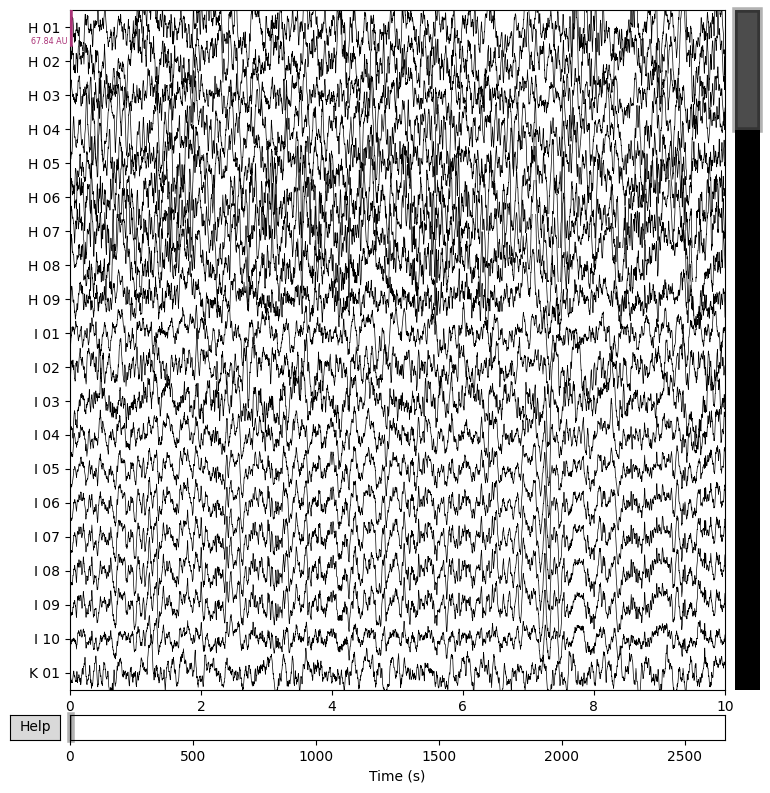

In [10]:
info = mne.create_info(
    ch_names=data.df_chan['name'].to_list(),
    ch_types=['misc'] * len(data.df_chan['name']),
    sfreq=fs
)

raw = mne.io.RawArray(data.ieeg, info)
# raw.compute_psd(picks='all', fmax=100).plot()
raw.plot()
plt.show()

In [ ]:
raw_epochs.plot_joint()

plt.show()

AttributeError: 'Epochs' object has no attribute 'plot_joint'

# Display Raw Data

#### Find contacts across electrodes that are located in the Hippocampus. 

In [4]:
idx = np.where(data.df_chan['DK_ROI'].str.contains(r'(hippo|Hippo|HIPPO)\w+'))
data.df_chan.iloc[idx]

/tmp/ipykernel_7433/1215535902.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  idx = np.where(data.df_chan['DK_ROI'].str.contains(r'(hippo|Hippo|HIPPO)\w+'))


elec_index  elec_label             DK_ROI  Prob Lobe  x17Networks  \
71           87         801   Left_Hippocampus  0.74    H       NO_ROI   
72           88         802   Left_Hippocampus  0.91    H       NO_ROI   
73           89         803   Left_Hippocampus  0.99    H       NO_ROI   
74           90         804   Left_Hippocampus  0.93    H       NO_ROI   
78          103         901   Left_Hippocampus  0.81    H       NO_ROI   
79          104         902   Left_Hippocampus  0.79    H       NO_ROI   
80          105         903   Left_Hippocampus  0.46    H       NO_ROI   
102         183        1401  Right_Hippocampus  0.27    H  Networks_15   
103         184        1402  Right_Hippocampus  0.60    H  Networks_15   
104         185        1403  Right_Hippocampus  0.74    H       NO_ROI   
105         186        1404  Right_Hippocampus  0.72    H       NO_ROI   

     Prob_1  x7Networks  Prob_2    BN_atlas  ...  brodmann Prob_4  perc_VTPM  \
71     0.00      NO_ROI    0.00  Hipp_L_2_1  ...        35   0.35     NO_ROI   
72     0.00      NO_ROI    0.00  Hipp_L_2_1  ...        20   0.88     NO_ROI   
73     0.00      NO_ROI    0.00  Hipp_L_2_1  ...        20   1.00     NO_ROI   
74     0.00      NO_ROI    0.00  Hipp_L_2_1  ...        20   1.00     NO_ROI   
78     0.00      NO_ROI    0.00  Hipp_L_2_2  ...        37   1.00     NO_ROI   
79     0.00      NO_ROI    0.00  Hipp_L_2_2  ...        37   1.00     NO_ROI   
80     0.00      NO_ROI    0.00  Hipp_L_2_2  ...        37   0.94     NO_ROI   
102    0.55  Networks_5    0.44  Hipp_R_2_1  ...        30   0.62     NO_ROI   
103    0.38  Networks_5    0.47  Hipp_R_2_1  ...        30   0.65     NO_ROI   
104    0.00      NO_ROI    0.00  Hipp_R_2_2  ...        20   0.92     NO_ROI   
105    0.00      NO_ROI    0.00  Hipp_R_2_2  ...        20   1.00     NO_ROI   

    Prob_5  Var16  data_chan      loc_1      loc_2      loc_3   name  
71     0.0    NaN         72 -25.062528  16.505682   4.994733   B 01  
72     0.0    NaN         73 -28.441106  16.699292   4.634672   B 02  
73     0.0    NaN         74 -31.859375  16.928825   4.281605   B 03  
74     0.0    NaN         75 -34.893603  17.125096   4.013083   B 04  
78     0.0    NaN         79 -29.537444   2.146746  12.712468   C 01  
79     0.0    NaN         80 -32.963128   1.901089  12.712735   C 02  
80     0.0    NaN         81 -36.689494   1.650701  12.785543   C 03  
102    0.0    NaN        113  21.814157  20.246080  -0.149293  B' 01  
103    0.0    NaN        114  25.153117  20.736965   0.645246  B' 02  
104    0.0    NaN        115  28.628871  21.275221   1.441458  B' 03  
105    0.0    NaN        116  31.952080  21.757915   2.184650  B' 04  

[11 rows x 21 columns]

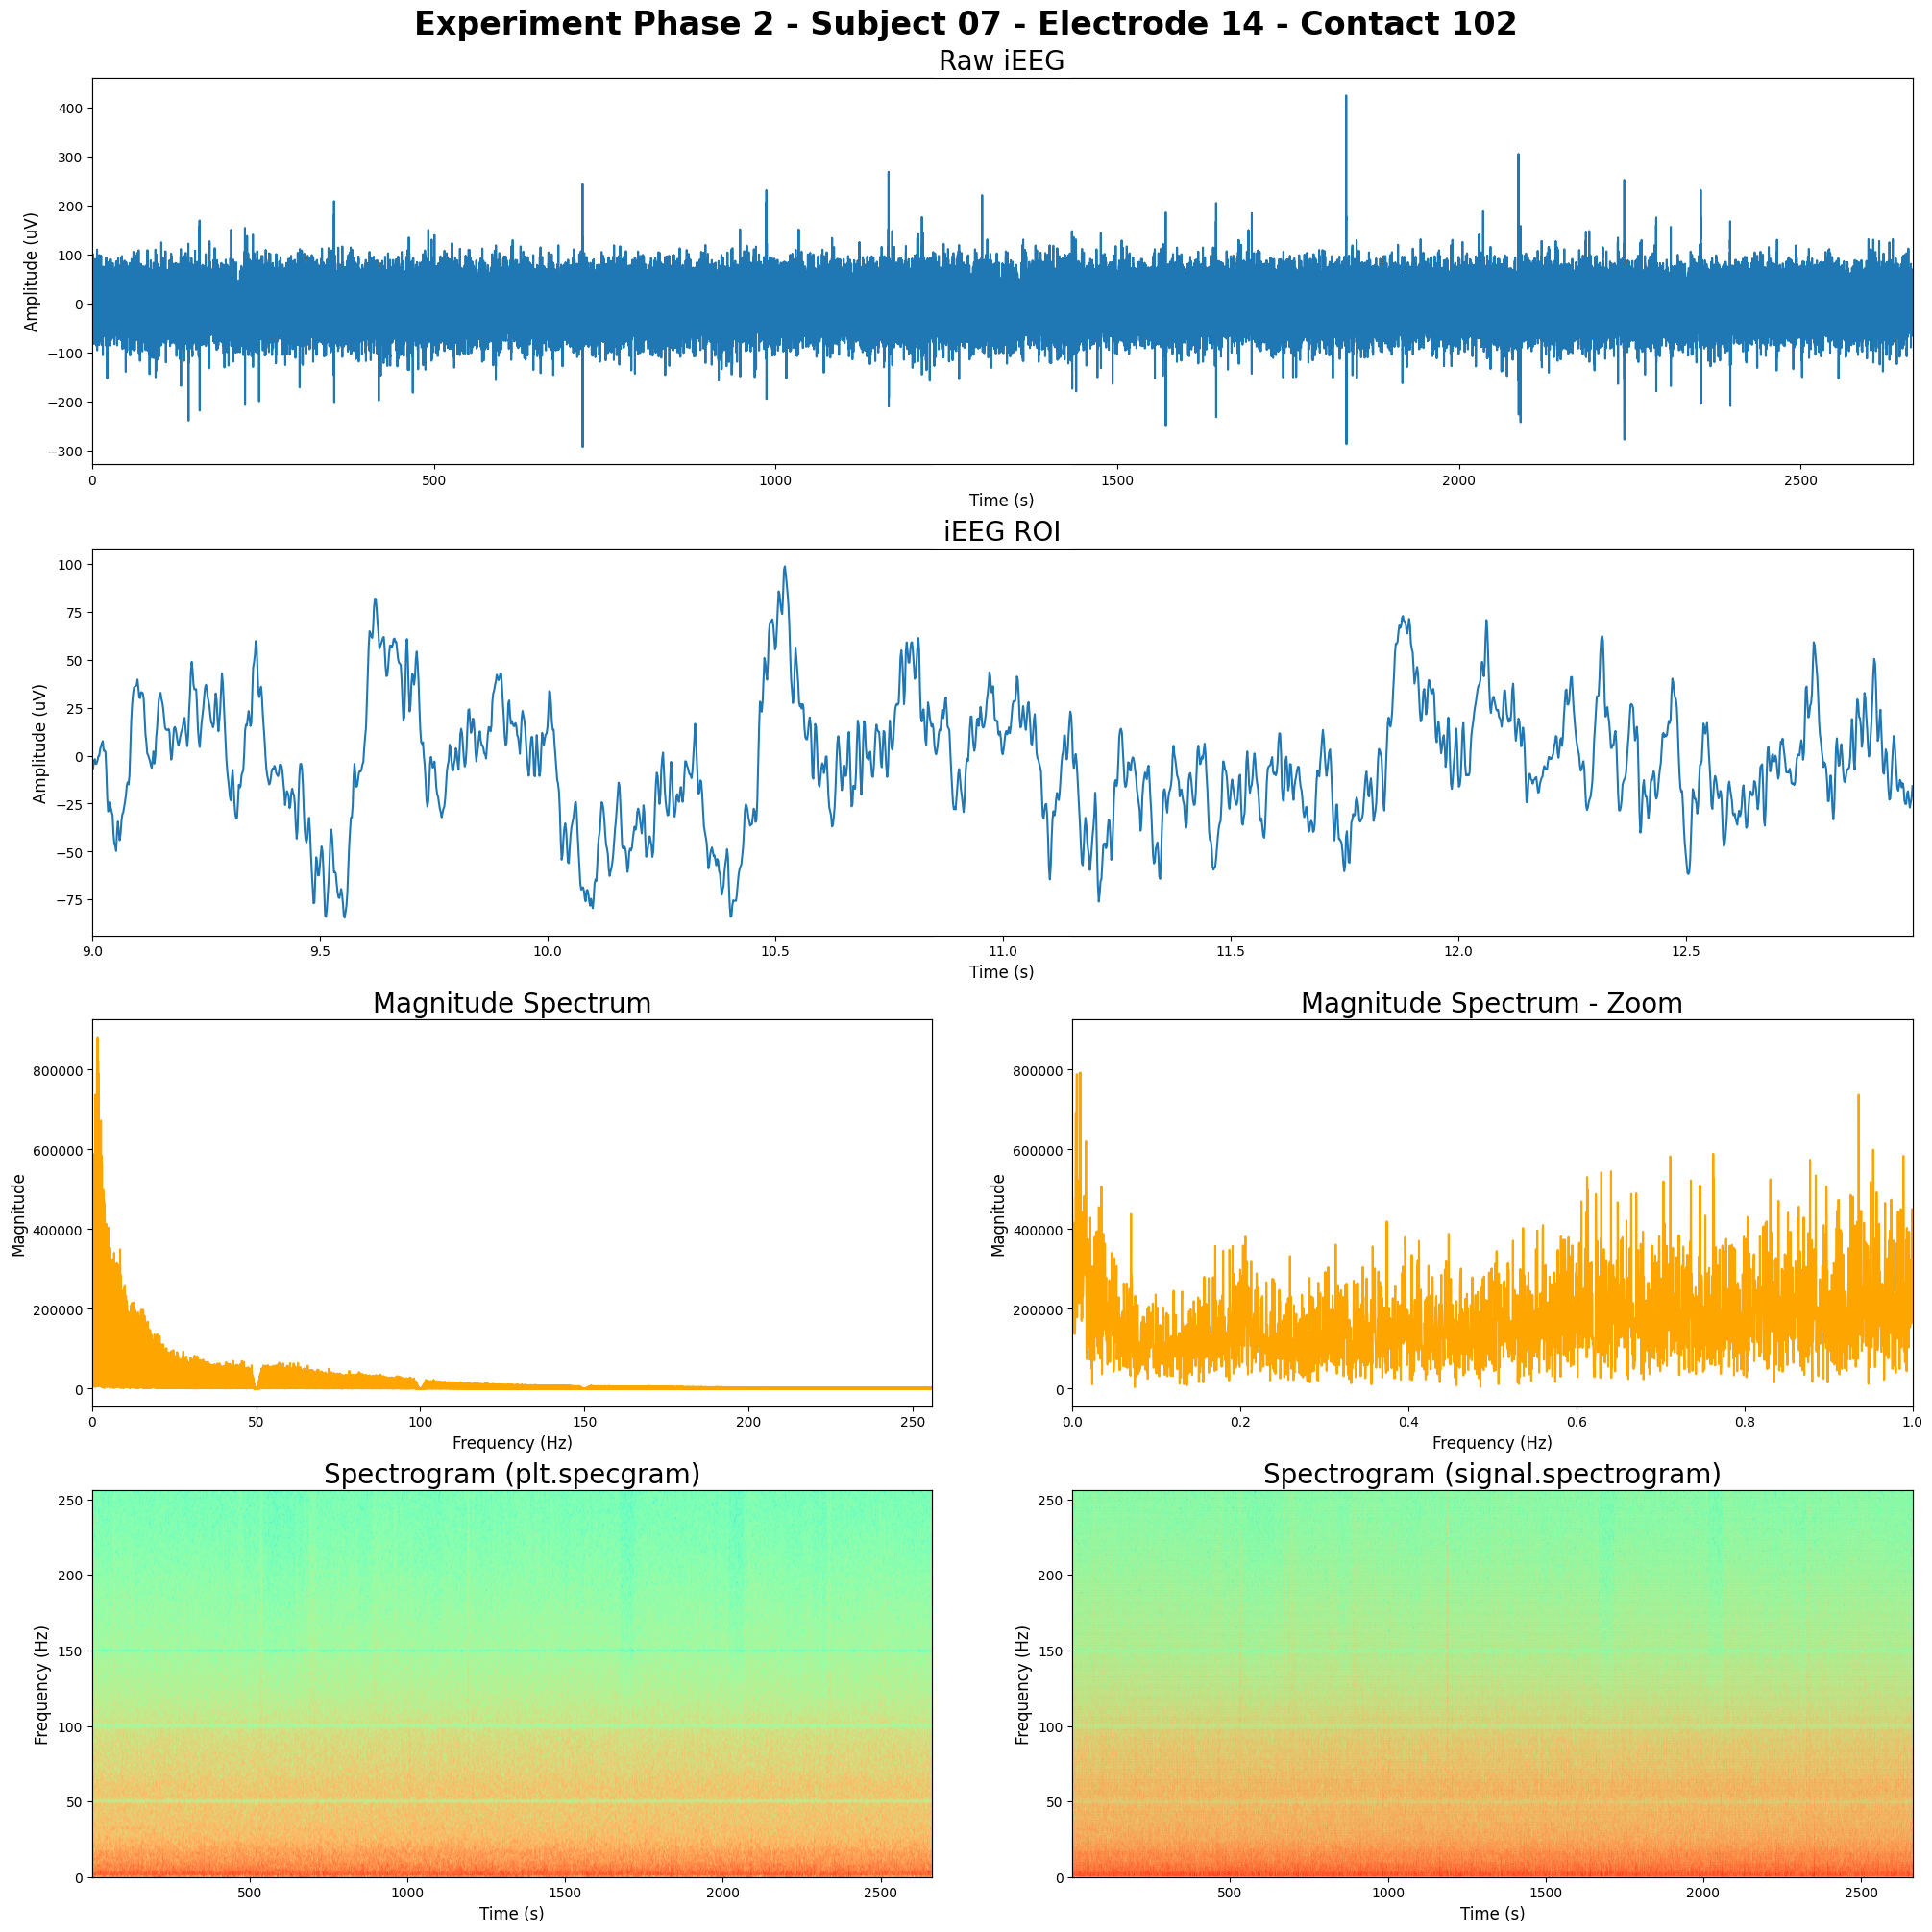

In [5]:
#******** Variable definitions ********
electrode_num = 14                                          # electrode to inspect
ieeg_contact_num = 102                                      # single iEEG contact to inspect
roi = [9, 13]                                               # ROI in seconds

#******** Static definitions ********
fs = 512                                                    # sample frequency
TT = data.ieeg.shape[1] / fs  # total time in seconds
t = np.arange(0, TT, 1/fs)                                  # full time vector
t_roi = np.arange(roi[0], roi[1], 1/fs)                     # ROI time vector

#******** Fourier transform ********
y = fft(data.ieeg[ieeg_contact_num, :])                     # FFT
xf = fftfreq(data.ieeg[ieeg_contact_num, :].size, 1/fs)     # Frequency vector
xf = xf[xf>=0]                                              # Only positive frequencies
y = np.abs(y)[:len(xf)]                                     # Magnitude of FFT (one sided)


#******** Plotting ********
fig, ax = plt.subplots(
    nrows=4, 
    ncols=2, 
    figsize=(20, 20),
    layout='constrained')
# Remove default x and y ticks (will be added during add_subplot)
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# Entire signal
gs1 = ax[0, 0].get_gridspec()
ax1 = fig.add_subplot(gs1[0, 0:])
ax1.plot(t, data.ieeg[ieeg_contact_num, :])
ax1.set_title('Raw iEEG', fontsize=20)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude (uV)', fontsize=12)
ax1.set_xlim([t[0], t[-1]])

# ROI
gs2 = ax[1, 0].get_gridspec()
ax2 = fig.add_subplot(gs2[1, 0:])
ax2.plot(t_roi, data.ieeg[ieeg_contact_num, roi[0]*fs:roi[1]*fs])
ax2.set_title('iEEG ROI', fontsize=20)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Amplitude (uV)', fontsize=12)
ax2.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs3 = ax[2, 0].get_gridspec()
ax3 = fig.add_subplot(gs3[2, 0])
ax3.plot(xf, y, color='orange')
ax3.set_title('Magnitude Spectrum', fontsize=20)
ax3.set_xlabel('Frequency (Hz)', fontsize=12)
ax3.set_ylabel('Magnitude', fontsize=12)
ax3.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs4 = ax[2, 0].get_gridspec()
ax4 = fig.add_subplot(gs4[2, 1])
ax4.plot(xf, y, color='orange')
ax4.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax4.set_xlabel('Frequency (Hz)', fontsize=12)
ax4.set_ylabel('Magnitude', fontsize=12)
ax4.set_xlim([0, 1])

# Spectrogram - Entire signal
gs5 = ax[3, 0].get_gridspec()
ax5 = fig.add_subplot(gs5[3, 0])
pxx, freqs, _t, img = ax5.specgram(data.ieeg[ieeg_contact_num, :], Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax5.set_title('Spectrogram (plt.specgram)', fontsize=20)
ax5.set_xlabel('Time (s)', fontsize=12)
ax5.set_ylabel('Frequency (Hz)', fontsize=12)

gs6 = ax[3, 0].get_gridspec()
ax6 = fig.add_subplot(gs6[3, 1])
_f, _t, Sxx = signal.spectrogram(data.ieeg[ieeg_contact_num, :], fs, nfft=512, noverlap=64)
ax6.pcolormesh(_t, _f, 10*np.log10(Sxx), shading='gouraud', cmap='rainbow')
ax6.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax6.set_xlabel('Time (s)', fontsize=12)
ax6.set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id} - Electrode {electrode_num} - Contact {ieeg_contact_num}", fontsize=24, fontweight='bold')
# plt.tight_layout()
plt.show()

# 1. Re-reference

In [9]:
reref = hp.Rereference()
neighbour_ieeg = data.ieeg[ieeg_contact_num+1, :]

print("\nPre re-referencing:")
print(data.ieeg[ieeg_contact_num, :])
print("\nNeighbour channel:")
print(neighbour_ieeg)
print()
tmp = reref.bipolar(data.ieeg[ieeg_contact_num, :], neighbour_ieeg)
print("\nPost re-referencing:")
print(tmp)


Pre re-referencing:
[29.11626816 28.53103828 29.72751808 ... 22.37561607 21.71739388
 20.18558502]

Neighbour channel:
[ 7.62319994  4.50672865  7.63183641 ...  7.60665512 11.34626102
 10.7547617 ]

Re-referencing method: 'bipolar'
Successfully re-referenced channel.

Post re-referencing:
[21.49306822 24.02430964 22.09568167 ... 14.76896095 10.37113285
  9.43082333]


In [14]:
#******** Initiate rereference object ********
reref = hp.Rereference()


#******** Re-reference single channel using bipolar montage ********
data_preref = data.ieeg[ieeg_contact_num, :] # Save state of data before re-referencing
neighbour_ieeg = data.ieeg[ieeg_contact_num+1, :]
data_reref = reref.bipolar(data.ieeg[ieeg_contact_num, :], neigbour_ieeg)

Re-referencing method: 'bipolar'
Successfully re-referenced channel.


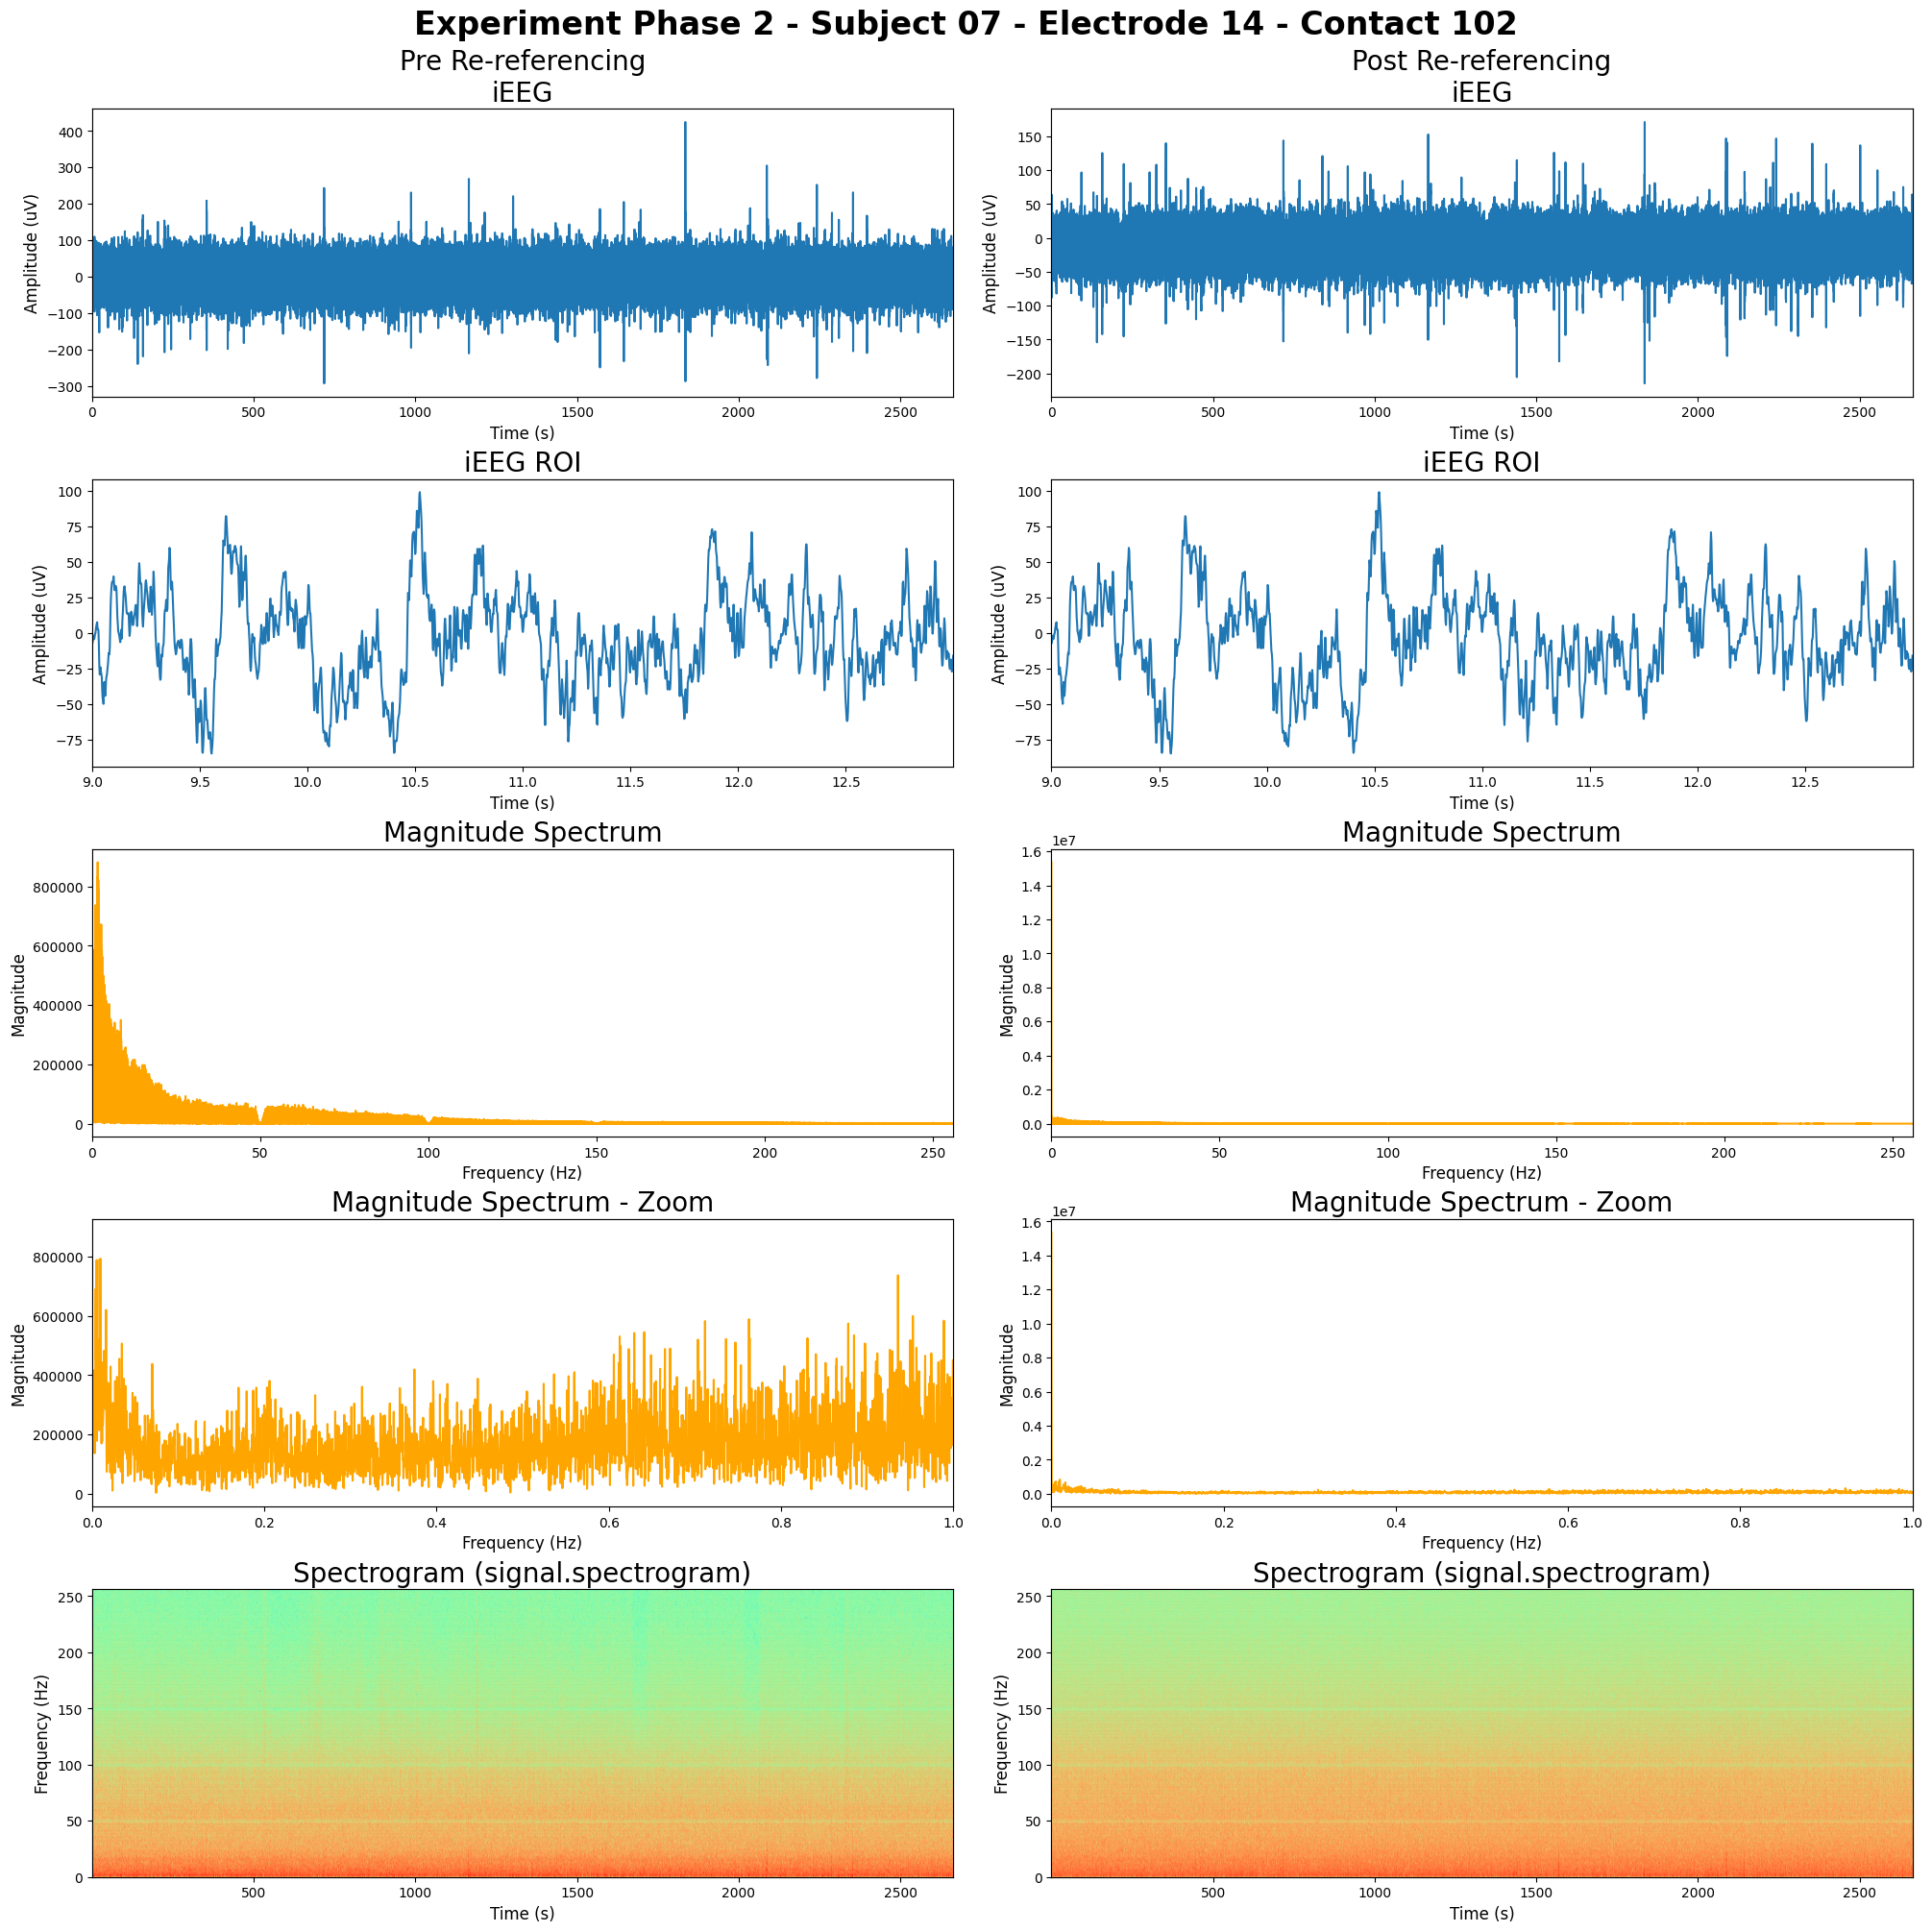

In [10]:
data_preref = data.ieeg[ieeg_contact_num, :] # Save state of data before re-referencing

#******** Fourier transform ********
# Pre-referencing
y_pre = fft(data_preref)                                    # FFT
xf_pre = fftfreq(data_preref.size, 1/fs)                    # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                  # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                         # Magnitude of FFT (one sided)
# Post-referencing
y = fft(tmp)                     # FFT
xf = fftfreq(tmp.size, 1/fs)     # Frequency vector
xf = xf[xf>=0]                                              # Only positive frequencies
y = np.abs(y)[:len(xf)]                                     # Magnitude of FFT (one sided)


#******** Plotting ********
fig, ax = plt.subplots(
    nrows=5, 
    ncols=2, 
    figsize=(20, 20),
    layout='constrained')
# Remove default x and y ticks (will be added during add_subplot)
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# Pre-referencing 
# Entire signal
gs1 = ax[0, 0].get_gridspec()
ax1 = fig.add_subplot(gs1[0, 0])
ax1.plot(t, data_preref)
ax1.set_title('Pre Re-referencing\niEEG', fontsize=20)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude (uV)', fontsize=12)
ax1.set_xlim([t[0], t[-1]])

# ROI
gs2 = ax[1, 0].get_gridspec()
ax2 = fig.add_subplot(gs2[1, 0])
ax2.plot(t_roi, data_preref[roi[0]*fs:roi[1]*fs])
ax2.set_title('iEEG ROI', fontsize=20)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Amplitude (uV)', fontsize=12)
ax2.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs3 = ax[2, 0].get_gridspec()
ax3 = fig.add_subplot(gs3[2, 0])
ax3.plot(xf_pre, y_pre, color='orange')
ax3.set_title('Magnitude Spectrum', fontsize=20)
ax3.set_xlabel('Frequency (Hz)', fontsize=12)
ax3.set_ylabel('Magnitude', fontsize=12)
ax3.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs4 = ax[3, 0].get_gridspec()
ax4 = fig.add_subplot(gs4[3, 0])
ax4.plot(xf_pre, y_pre, color='orange')
ax4.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax4.set_xlabel('Frequency (Hz)', fontsize=12)
ax4.set_ylabel('Magnitude', fontsize=12)
ax4.set_xlim([0, 1])

gs5 = ax[4, 0].get_gridspec()
ax5 = fig.add_subplot(gs5[4, 0])
_f_pre, _t_pre, Sxx_pre = signal.spectrogram(data_preref, fs, nfft=512, noverlap=64)
ax5.pcolormesh(_t_pre, _f_pre, 10*np.log10(Sxx_pre), shading='gouraud', cmap='rainbow')
ax5.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax5.set_xlabel('Time (s)', fontsize=12)
ax5.set_ylabel('Frequency (Hz)', fontsize=12)

# Post-referencing 
# Entire signal
gs6 = ax[0, 0].get_gridspec()
ax6 = fig.add_subplot(gs6[0, 1])
ax6.plot(t, tmp)
ax6.set_title('Post Re-referencing\niEEG', fontsize=20)
ax6.set_xlabel('Time (s)', fontsize=12)
ax6.set_ylabel('Amplitude (uV)', fontsize=12)
ax6.set_xlim([t[0], t[-1]])

# ROI
gs7 = ax[1, 0].get_gridspec()
ax7 = fig.add_subplot(gs7[1, 1])
ax7.plot(t_roi, data.ieeg[ieeg_contact_num, roi[0]*fs:roi[1]*fs])
ax7.set_title('iEEG ROI', fontsize=20)
ax7.set_xlabel('Time (s)', fontsize=12)
ax7.set_ylabel('Amplitude (uV)', fontsize=12)
ax7.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs8 = ax[2, 0].get_gridspec()
ax8 = fig.add_subplot(gs8[2, 1])
ax8.plot(xf, y, color='orange')
ax8.set_title('Magnitude Spectrum', fontsize=20)
ax8.set_xlabel('Frequency (Hz)', fontsize=12)
ax8.set_ylabel('Magnitude', fontsize=12)
ax8.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs9 = ax[3, 0].get_gridspec()
ax9 = fig.add_subplot(gs9[3, 1])
ax9.plot(xf, y, color='orange')
ax9.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax9.set_xlabel('Frequency (Hz)', fontsize=12)
ax9.set_ylabel('Magnitude', fontsize=12)
ax9.set_xlim([0, 1])

gs10 = ax[4, 0].get_gridspec()
ax10 = fig.add_subplot(gs6[4, 1])
_f, _t, Sxx = signal.spectrogram(tmp, fs, nfft=512, noverlap=64)
ax10.pcolormesh(_t, _f, 10*np.log10(Sxx), shading='gouraud', cmap='rainbow')
ax10.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax10.set_xlabel('Time (s)', fontsize=12)
ax10.set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id} - Electrode {electrode_num} - Contact {ieeg_contact_num}", fontsize=24, fontweight='bold')
# plt.tight_layout()
plt.show()

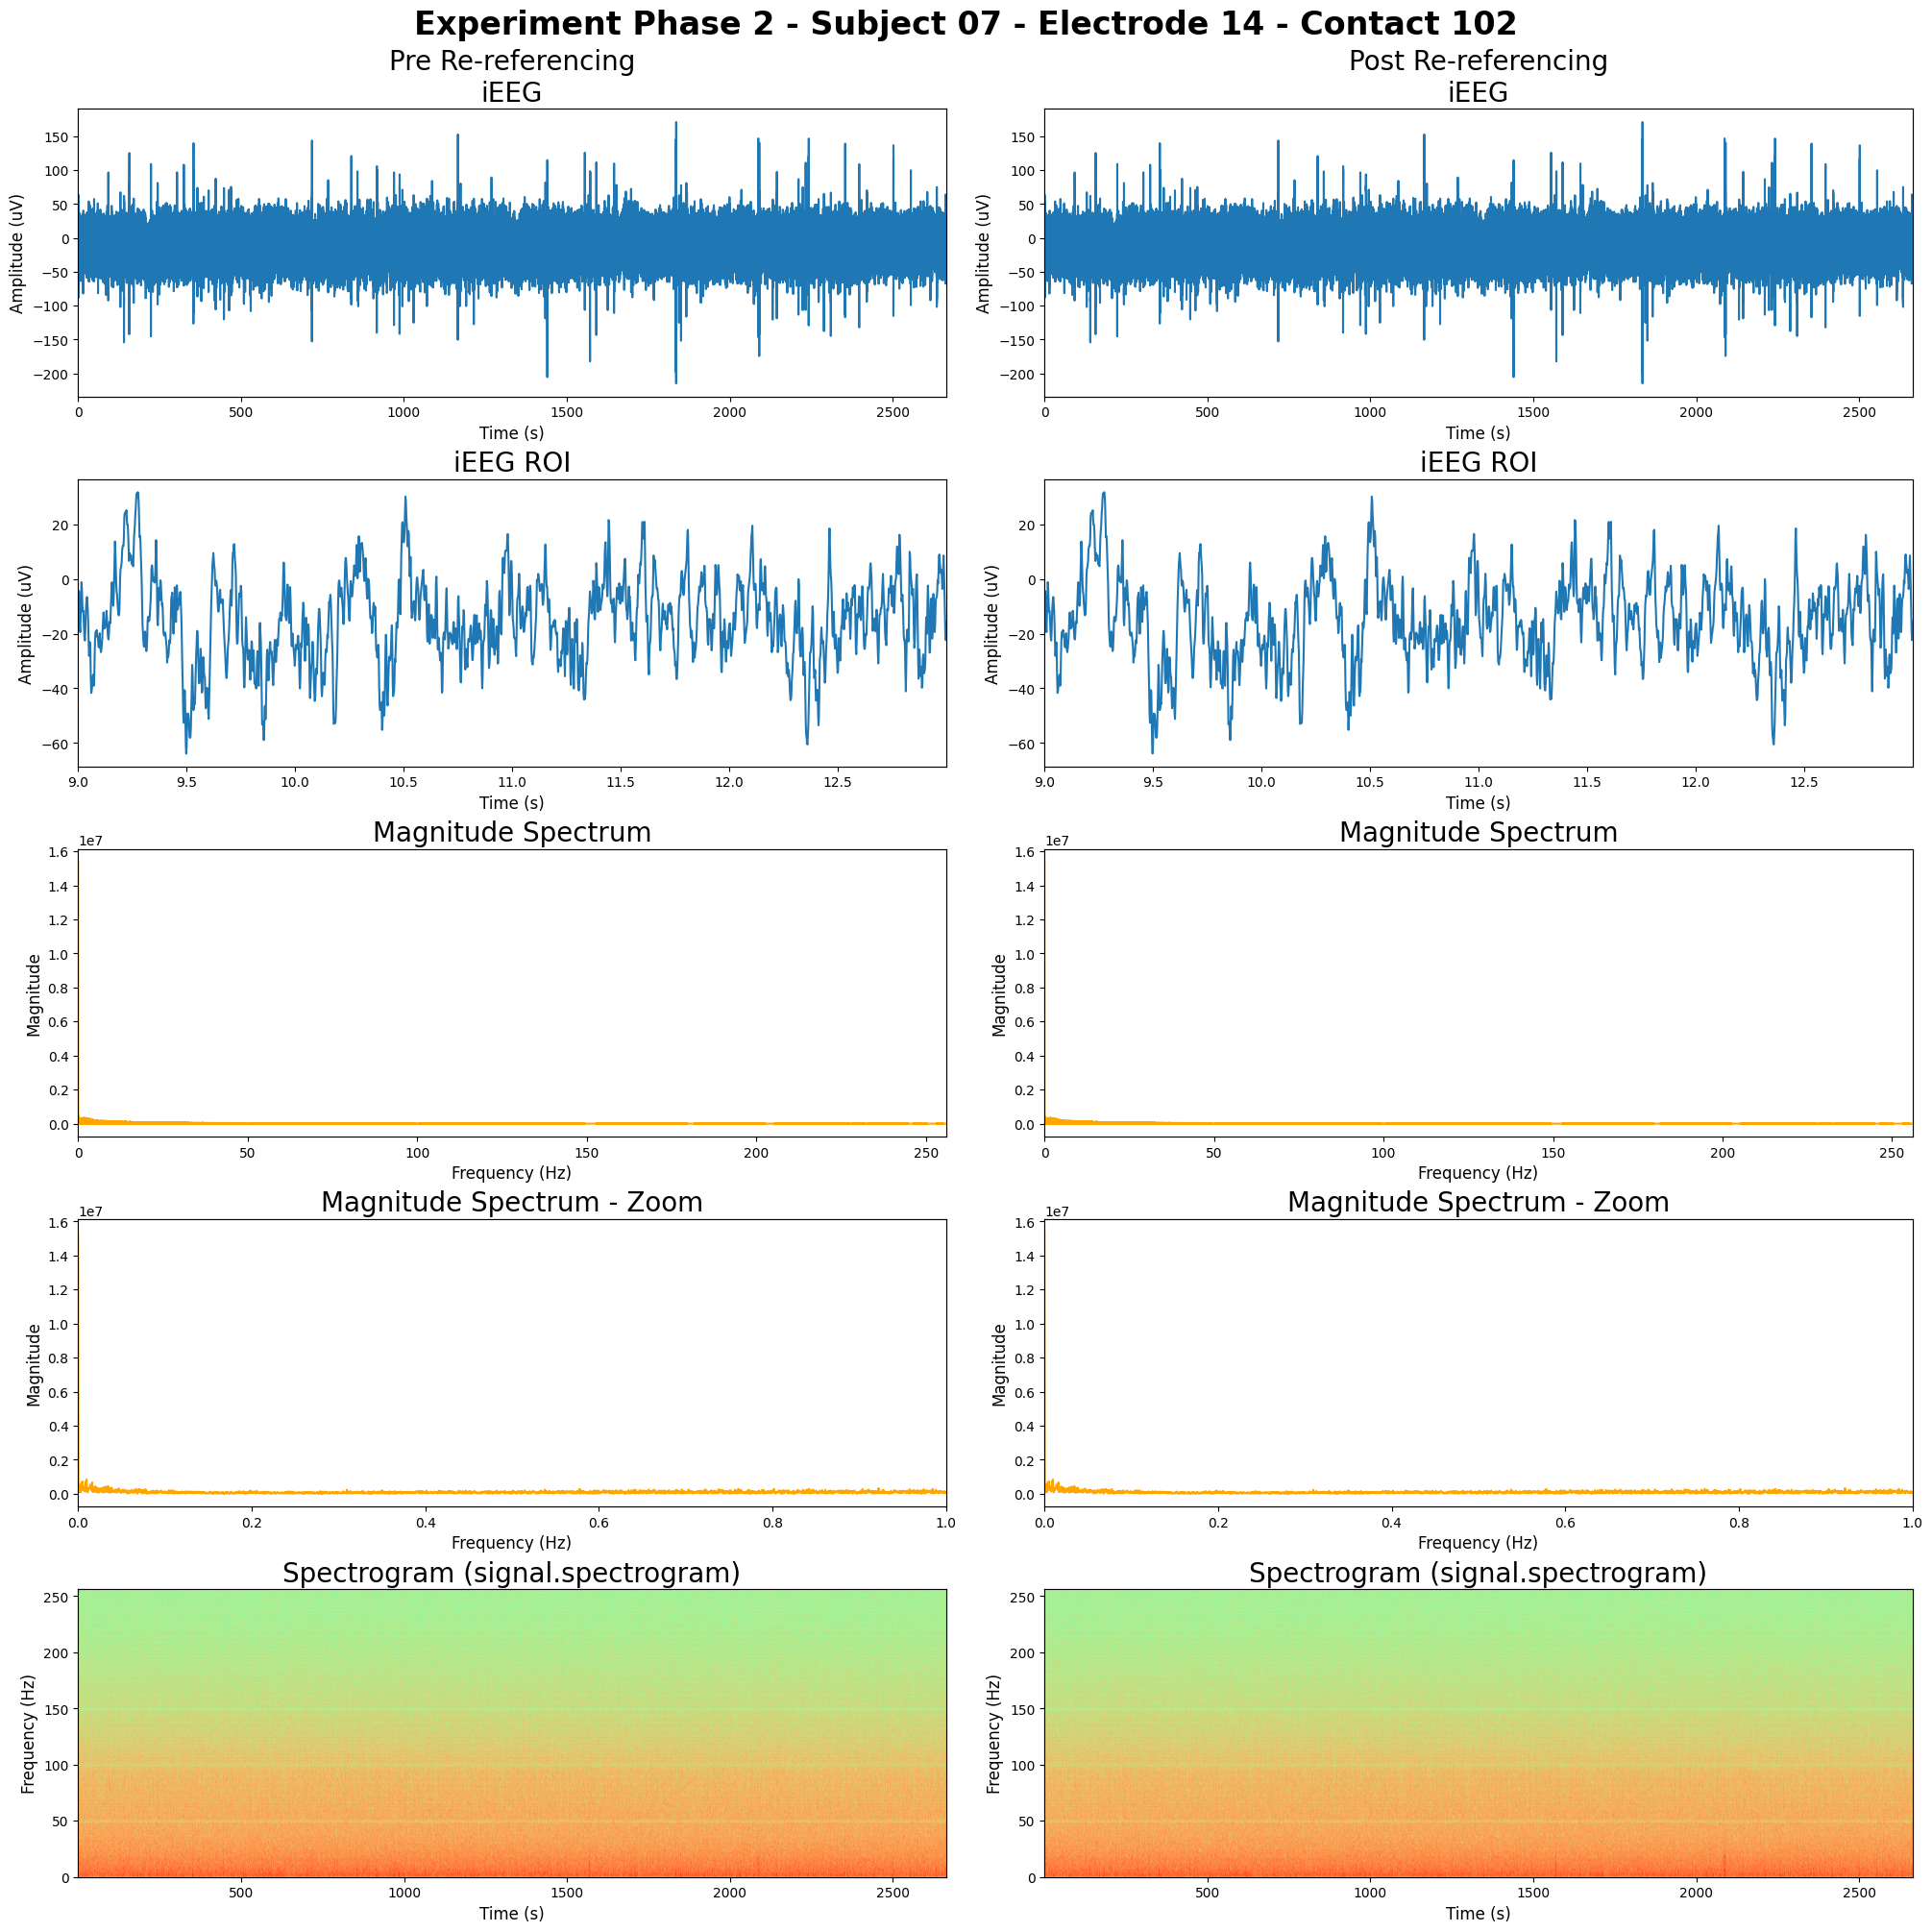

In [18]:
#******** Fourier transform ********
# Pre-referencing
y_pre = fft(data_preref)                                    # FFT
xf_pre = fftfreq(data_preref.size, 1/fs)                    # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                  # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                         # Magnitude of FFT (one sided)
# Post-referencing
y = fft(data.ieeg[ieeg_contact_num, :])                     # FFT
xf = fftfreq(data.ieeg[ieeg_contact_num, :].size, 1/fs)     # Frequency vector
xf = xf[xf>=0]                                              # Only positive frequencies
y = np.abs(y)[:len(xf)]                                     # Magnitude of FFT (one sided)


#******** Plotting ********
fig, ax = plt.subplots(
    nrows=5, 
    ncols=2, 
    figsize=(20, 20),
    layout='constrained')
# Remove default x and y ticks (will be added during add_subplot)
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# Pre-referencing 
# Entire signal
gs1 = ax[0, 0].get_gridspec()
ax1 = fig.add_subplot(gs1[0, 0])
ax1.plot(t, data_preref)
ax1.set_title('Pre Re-referencing\niEEG', fontsize=20)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude (uV)', fontsize=12)
ax1.set_xlim([t[0], t[-1]])

# ROI
gs2 = ax[1, 0].get_gridspec()
ax2 = fig.add_subplot(gs2[1, 0])
ax2.plot(t_roi, data_preref[roi[0]*fs:roi[1]*fs])
ax2.set_title('iEEG ROI', fontsize=20)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Amplitude (uV)', fontsize=12)
ax2.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs3 = ax[2, 0].get_gridspec()
ax3 = fig.add_subplot(gs3[2, 0])
ax3.plot(xf_pre, y_pre, color='orange')
ax3.set_title('Magnitude Spectrum', fontsize=20)
ax3.set_xlabel('Frequency (Hz)', fontsize=12)
ax3.set_ylabel('Magnitude', fontsize=12)
ax3.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs4 = ax[3, 0].get_gridspec()
ax4 = fig.add_subplot(gs4[3, 0])
ax4.plot(xf_pre, y_pre, color='orange')
ax4.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax4.set_xlabel('Frequency (Hz)', fontsize=12)
ax4.set_ylabel('Magnitude', fontsize=12)
ax4.set_xlim([0, 1])

gs5 = ax[4, 0].get_gridspec()
ax5 = fig.add_subplot(gs5[4, 0])
_f_pre, _t_pre, Sxx_pre = signal.spectrogram(data_preref, fs, nfft=512, noverlap=64)
ax5.pcolormesh(_t_pre, _f_pre, 10*np.log10(Sxx_pre), shading='gouraud', cmap='rainbow')
ax5.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax5.set_xlabel('Time (s)', fontsize=12)
ax5.set_ylabel('Frequency (Hz)', fontsize=12)

# Post-referencing 
# Entire signal
gs6 = ax[0, 0].get_gridspec()
ax6 = fig.add_subplot(gs6[0, 1])
ax6.plot(t, data.ieeg[ieeg_contact_num, :])
ax6.set_title('Post Re-referencing\niEEG', fontsize=20)
ax6.set_xlabel('Time (s)', fontsize=12)
ax6.set_ylabel('Amplitude (uV)', fontsize=12)
ax6.set_xlim([t[0], t[-1]])

# ROI
gs7 = ax[1, 0].get_gridspec()
ax7 = fig.add_subplot(gs7[1, 1])
ax7.plot(t_roi, data.ieeg[ieeg_contact_num, roi[0]*fs:roi[1]*fs])
ax7.set_title('iEEG ROI', fontsize=20)
ax7.set_xlabel('Time (s)', fontsize=12)
ax7.set_ylabel('Amplitude (uV)', fontsize=12)
ax7.set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum - Entire signal
gs8 = ax[2, 0].get_gridspec()
ax8 = fig.add_subplot(gs8[2, 1])
ax8.plot(xf, y, color='orange')
ax8.set_title('Magnitude Spectrum', fontsize=20)
ax8.set_xlabel('Frequency (Hz)', fontsize=12)
ax8.set_ylabel('Magnitude', fontsize=12)
ax8.set_xlim([xf[0], xf[-1]])

# Magnitude spectrum - Zoom
gs9 = ax[3, 0].get_gridspec()
ax9 = fig.add_subplot(gs9[3, 1])
ax9.plot(xf, y, color='orange')
ax9.set_title('Magnitude Spectrum - Zoom', fontsize=20)
ax9.set_xlabel('Frequency (Hz)', fontsize=12)
ax9.set_ylabel('Magnitude', fontsize=12)
ax9.set_xlim([0, 1])

gs10 = ax[4, 0].get_gridspec()
ax10 = fig.add_subplot(gs6[4, 1])
_f, _t, Sxx = signal.spectrogram(data.ieeg[ieeg_contact_num, :], fs, nfft=512, noverlap=64)
ax10.pcolormesh(_t, _f, 10*np.log10(Sxx), shading='gouraud', cmap='rainbow')
ax10.set_title('Spectrogram (signal.spectrogram)', fontsize=20)
ax10.set_xlabel('Time (s)', fontsize=12)
ax10.set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id} - Electrode {electrode_num} - Contact {ieeg_contact_num}", fontsize=24, fontweight='bold')
# plt.tight_layout()
plt.show()

# 2. Filter Signal

In [ ]:
def digital_filter(in_signal=None, order=4, cutoff=500, fs=1000, filter_type='high', apply_filter=False, show_bodeplot=True, show_impulse_response=True, len_impulse=1000):
    """digital_filter Create a digital filter using scipy's butter function.

    Create a digital filter using scipy's butter function and compute the
    filter frequency response. The filter frequency response is always plotted
    as part in ensuring the desired filter design.

    Args:
        in_signal (_type_, optional): If specified and apply_filter is set to True, the filter is applied to the signal 
                                      and the filtered signal is returned. Defaults to None.
        order (int, optional): The order of the filter. Defaults to 4.
        cutoff (int or vector, optional): The cutoff frequency of the filter (in Hz). If filter_type is 'bandpass' or
                                          'bandstop' cutoff is a length-2 vector. Defaults to 500.
        fs (int, optional): The sampling frequency used to sample the signal. Defaults to 1000.
        filter_type (str, optional): The type of filter ('lowpass', 'highpass', 'bandstop', 'bandpass'). Defaults to 'high'.
        apply_filter (bool, optional): If True then the filter is applied to the signal in_signal. Filter will be applied forward
                                       and backward on the signal to eliminate phase shift. Defaults to False.
        show_bodeplot (bool, optional): If True then the bode plot of the filter frequency response is plotted. Defaults to True.
        show_impulse_response (bool, optional): If True then the impulse response of the filter is plotted. Defaults to True.
        len_impulse (int, optional): The length of the impulse response. If not specified defaults to 1000.

    Returns:
        b, a (ndarray): Default setting for function is to return the 
                        filter coefficients.
        out_signal (ndarray): If apply_filter is set to True and in_signal 
                              is given, the function will apply the digital 
                              filter and return the filtered signal.
    """
    # Create digital filter
    b, a = signal.butter(N=order, Wn=cutoff, btype=filter_type, fs=fs, analog=False)
    
    # Compute digital filter frequency response
    w, h = signal.freqz(b, a, fs=fs)
    
    # Generate and compute impulse response
    impulse = signal.unit_impulse(len_impulse)                                  # create impulse
    t_impulse = np.arange(-(len_impulse//10), len_impulse-(len_impulse//10))    # create time vector for impulse
    response = signal.lfilter(b, a, impulse)                                    # compute filter response to impulse
    
    # Plotting
    if show_bodeplot and show_impulse_response:
        fig, ax = plt.subplots(1, 2, figsize=(20, 7))
        # Bode plot
        ax[0].semilogx(w, 20*np.log10(abs(h)), linewidth=3)
        ax[0].set_title("Digital Filter Frequency Response", fontsize=20)
        ax[0].set_xlabel("Frequency [Hz]", fontsize=16)
        ax[0].set_ylabel("Amplitude [dB]", fontsize=16)
        ax[0].grid(which='both', axis='both')
        if filter_type in ('low', 'lowpass'): ax[0].margins(0, 0.15)
        if filter_type in ('high', 'highpass'): ax[0].margins(0.15, 0.1)
        if filter_type in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].axvline(cutoff[0], color='orange', label=f"Cutoff frequency start ({cutoff[0]} Hz)", linewidth=2, linestyle='--')
            ax[0].axvline(cutoff[1], color='orange', label=f"Cutoff frequency stop ({cutoff[1]} Hz)", linewidth=2, linestyle='--')
        if filter_type not in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].semilogx(cutoff, 20*np.log10(0.5*np.sqrt(2)), '*') # plot a star symbol at -3 dB attenuation
            ax[0].axvline(cutoff, color='orange', label=f"Cutoff frequency ({cutoff} Hz)", linewidth=2, linestyle='--')
        # Impulse response plot
        ax[1].plot(t_impulse, impulse, 'b-', label='Impulse')
        ax[1].plot(t_impulse, response, 'g-', linewidth=2, label='Response')
        ax[1].set_title('Impulse and Response of Digital Filter', fontsize=20)
        ax[1].set_xlabel('Time [sec]', fontsize=16)
        ax[1].set_ylabel('Amplitude', fontsize=16)
        ax[1].grid(which='both', axis='both')
        plt.legend(loc='best', fontsize=12, shadow=True)
        plt.tight_layout()
    elif show_bodeplot:
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        ax[0].semilogx(w, 20*np.log10(abs(h)), linewidth=3)
        ax[0].set_title("Digital Filter Frequency Response", fontsize=20)
        ax[0].set_xlabel("Frequency [Hz]", fontsize=16)
        ax[0].set_ylabel("Amplitude [dB]", fontsize=16)
        ax[0].grid(which='both', axis='both')
        if filter_type in ('low', 'lowpass'): ax[0].margins(0, 0.15)
        if filter_type in ('high', 'highpass'): ax[0].margins(0.15, 0.1)
        if filter_type in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].axvline(cutoff[0], color='orange', label=f"Cutoff frequency start ({cutoff[0]} Hz)", linewidth=2, linestyle='--')
            ax[0].axvline(cutoff[1], color='orange', label=f"Cutoff frequency stop ({cutoff[1]} Hz)", linewidth=2, linestyle='--')
        if filter_type not in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].semilogx(cutoff, 20*np.log10(0.5*np.sqrt(2)), '*') # plot a star symbol at -3 dB attenuation
            ax[0].axvline(cutoff, color='orange', label=f"Cutoff frequency ({cutoff} Hz)", linewidth=2, linestyle='--')
        plt.legend(loc='best', fontsize=12, shadow=True)
        plt.tight_layout()
    elif show_impulse_response:
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        ax[0].plot(t_impulse, impulse, 'b-', label='Impulse')
        ax[0].plot(t_impulse, response, 'g-', linewidth=2, label='Response')
        ax[0].set_title('Impulse and Response of Digital Filter', fontsize=20)
        ax[0].set_xlabel('Time [sec]', fontsize=16)
        ax[0].set_ylabel('Amplitude', fontsize=16)
        ax[0].grid(which='both', axis='both')
        plt.legend(loc='best', fontsize=12, shadow=True)
        plt.tight_layout()
    else:
        pass
    
    if apply_filter == True and in_signal is not None:
        # Apply filter forward and backward to eliminate phase shift
        out_signal = signal.sosfiltfilt(b, a, in_signal)
        return out_signal
    else:
        # (Defualt) Return the filter coefficients
        return b, a

In [ ]:
#******** Highpass filter data ********
# Note:
#   Remove low frequency drifts.
data.ieeg_filtered = digital_filter(in_signal=data.ieeg[ieeg_contact_num, :],
                                        order=5,
                                        cutoff=2,
                                        filter_type='highpass',
                                        fs=fs,
                                        apply_filter=True)


#******** Fourier transform ********
y_pre = fft(data.ieeg[ieeg_contact_num, :])                      # FFT
xf_pre = fftfreq(data.ieeg[ieeg_contact_num, :].size, 1/fs)      # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                      # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                             # Magnitude of FFT (one sided)

y_post = fft(data.ieeg_filtered)                             # FFT
xf_post = fftfreq(data.ieeg_filtered.size, 1/fs)             # Frequency vector
xf_post = xf_post[xf_post>=0]                                   # Only positive frequencies
y_post = np.abs(y_post)[:len(xf_post)]                          # Magnitude of FFT (one sided)


#******** Plotting (pre filtering) ********
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Entire signal
ax[0,0].plot(t, data.ieeg[ieeg_contact_num, :])
ax[0,0].set_title('Pre Filter\nRaw iEEG', fontsize=20)
ax[0,0].set_xlabel('Time (s)', fontsize=12)
ax[0,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,0].set_xlim([t[0], t[-1]])

# ROI
ax[1,0].plot(t_roi, data.ieeg[ieeg_contact_num, roi[0]*fs:roi[1]*fs])
ax[1,0].set_title('iEEG ROI', fontsize=20)
ax[1,0].set_xlabel('Time (s)', fontsize=12)
ax[1,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,0].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,0].plot(xf_pre, y_pre, color='orange')
ax[2,0].set_title('Magnitude Spectrum', fontsize=20)
ax[2,0].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,0].set_ylabel('Magnitude', fontsize=12)
ax[2,0].set_xlim([xf_pre[0], xf_pre[-1]])

# Spectrogram
pxx_pre, freqs_pre, _t_pre, img_pre = ax[3,0].specgram(data.ieeg[ieeg_contact_num, :], Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,0].set_title('Spectrogram', fontsize=20)
ax[3,0].set_xlabel('Time (s)', fontsize=12)
ax[3,0].set_ylabel('Frequency (Hz)', fontsize=12)

#******** Plotting (post filtering) ********
# Entire signal
ax[0,1].plot(t, data.ieeg_filtered)
ax[0,1].set_title('Post Filter\nRaw iEEG', fontsize=20)
ax[0,1].set_xlabel('Time (s)', fontsize=12)
ax[0,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,1].set_xlim([t[0], t[-1]])

# ROI
ax[1,1].plot(t_roi, data.ieeg_filtered[roi[0]*fs:roi[1]*fs])
ax[1,1].set_title('iEEG ROI', fontsize=20)
ax[1,1].set_xlabel('Time (s)', fontsize=12)
ax[1,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,1].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,1].plot(xf_post, y_post, color='orange')
ax[2,1].set_title('Magnitude Spectrum', fontsize=20)
ax[2,1].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,1].set_ylabel('Magnitude', fontsize=12)
ax[2,1].set_xlim([xf_post[0], xf_post[-1]])

# Spectrogram
pxx_post, freqs_post, _t_post, img_post = ax[3,1].specgram(data.ieeg_filtered, Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,1].set_title('Spectrogram', fontsize=20)
ax[3,1].set_xlabel('Time (s)', fontsize=12)
ax[3,1].set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id}", fontsize=24, fontweight='bold')
plt.tight_layout()

In [ ]:
# temporary variable holding pre highpass filtered data
tmp_dataone_highpass = data.ieeg_filtered

#******** Bandstop filter data ********
# Note:
#   Remove powerline frequency noise.
data.ieeg_filtered = digital_filter(in_signal=data.ieeg_filtered,
                                        order=5,
                                        cutoff=[48, 52],
                                        filter_type='bandstop',
                                        fs=fs,
                                        apply_filter=True)


#******** Fourier transform ********
# pre filtering
y_pre = fft(tmp_dataone_highpass)                               # FFT
xf_pre = fftfreq(tmp_dataone_highpass.size, 1/fs)               # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                      # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                             # Magnitude of FFT (one sided)
# post filtering
y_post = fft(data.ieeg_filtered)                             # FFT
xf_post = fftfreq(data.ieeg_filtered.size, 1/fs)             # Frequency vector
xf_post = xf_post[xf_post>=0]                                   # Only positive frequencies
y_post = np.abs(y_post)[:len(xf_post)]                          # Magnitude of FFT (one sided)


#******** Plotting (pre filtering) ********
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Entire signal
ax[0,0].plot(t, tmp_dataone_highpass)
ax[0,0].set_title('Pre Filter\nRaw iEEG', fontsize=20)
ax[0,0].set_xlabel('Time (s)', fontsize=12)
ax[0,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,0].set_xlim([t[0], t[-1]])

# ROI
ax[1,0].plot(t_roi, tmp_dataone_highpass[roi[0]*fs:roi[1]*fs])
ax[1,0].set_title('iEEG ROI', fontsize=20)
ax[1,0].set_xlabel('Time (s)', fontsize=12)
ax[1,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,0].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,0].plot(xf_pre, y_pre, color='orange')
ax[2,0].set_title('Magnitude Spectrum', fontsize=20)
ax[2,0].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,0].set_ylabel('Magnitude', fontsize=12)
ax[2,0].set_xlim([xf_pre[0], xf_pre[-1]])

# Spectrogram
pxx_pre, freqs_pre, _t_pre, img_pre = ax[3,0].specgram(tmp_dataone_highpass, Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,0].set_title('Spectrogram', fontsize=20)
ax[3,0].set_xlabel('Time (s)', fontsize=12)
ax[3,0].set_ylabel('Frequency (Hz)', fontsize=12)

#******** Plotting (post filtering) ********
# Entire signal
ax[0,1].plot(t, data.ieeg_filtered)
ax[0,1].set_title('Post Filter\nRaw iEEG', fontsize=20)
ax[0,1].set_xlabel('Time (s)', fontsize=12)
ax[0,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,1].set_xlim([t[0], t[-1]])

# ROI
ax[1,1].plot(t_roi, data.ieeg_filtered[roi[0]*fs:roi[1]*fs])
ax[1,1].set_title('iEEG ROI', fontsize=20)
ax[1,1].set_xlabel('Time (s)', fontsize=12)
ax[1,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,1].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,1].plot(xf_post, y_post, color='orange')
ax[2,1].set_title('Magnitude Spectrum', fontsize=20)
ax[2,1].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,1].set_ylabel('Magnitude', fontsize=12)
ax[2,1].set_xlim([xf_post[0], xf_post[-1]])

# Spectrogram
pxx_post, freqs_post, _t_post, img_post = ax[3,1].specgram(data.ieeg_filtered, Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,1].set_title('Spectrogram', fontsize=20)
ax[3,1].set_xlabel('Time (s)', fontsize=12)
ax[3,1].set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Experiment Phase {experiment_phase_of_interest} - Subject {data.subject_id}", fontsize=24, fontweight='bold')
plt.tight_layout()

# Inspect Signal Phase

In [ ]:
x = fft(data.ieeg_filtered)
xf = fftfreq(data.ieeg_filtered.size, 1/fs)
xf = xf[xf>=0]
x = np.abs(x)[:len(xf)]

plt.plot(xf, x)
plt.xlim(-2, 10)